## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with the nuisance parameter bias

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../../../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Methods

In [2]:
def plot_asimov_spectrum(fig, ax):
    model = dataset_asimov_N.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[1],
        label="Asimov Fit with nui.",
        linestyle="solid",
    )

    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[3],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[0],
        linestyle="dashed",
        label="Asimov Fit w/0 nui.",
    )
    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[2],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0]
    dataset_asimov.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color="black",
        label="Input",
        linestyle="dotted",
    )

    ax.legend(loc="lower left")
    ax.set_xlim(0.3, 100)
    ax.set_ylim(1e-13, 2e-12)

## Import

In [3]:
config = Dataset_load.load_config()
colors = config['colors']['three']

colors
import ast

colors[1] = ast.literal_eval(colors[1])
colors[2] = ast.literal_eval(colors[2])
colors[3] = ast.literal_eval(colors[3])

### Datasets

In [4]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
lambda_ = Parameter("lambda_", value=1 / 60)

dataset_asimov = Dataset_load.create_asimov(
    model="ecpl", source="PKSflare", parameters=Parameters([scaled_amplitude, lambda_])
)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


In [5]:
norm = 0.0
tilt = 0.0
bias = 0.1
resolution = 0.0

bias_values = [0,0.05, 0.1, 0.15, 0.2]

In [6]:
setup = Setup(dataset_input=dataset_asimov)
datasets , datasets_N = [], []
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
for i in range(len(bias_values)):
    a, an = setup.run()
    # irf model
    setup.set_irf_model(an)
    an.models.parameters['resolution'].frozen = True
    an.irf_model.parameters['tilt'].frozen = True
    an.irf_model.parameters['norm'].frozen = True
    setup.set_irf_prior(an, bias, resolution, norm, tilt)
    datasets.append(a)
    datasets_N.append(an)

dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
dataset_asimov_N.models.parameters['resolution'].frozen = True
dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
dataset_asimov_N.irf_model.parameters['norm'].frozen = True
setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

In [7]:
print(dataset_asimov_N.models.parameters.to_table())

    type        name       value         unit        error      min        max     frozen is_norm link     prior    
------------ ---------- ----------- -------------- --------- ---------- ---------- ------ ------- ---- -------------
    spectral      index  2.3000e+00                0.000e+00        nan        nan  False   False               None
    spectral  amplitude  1.0000e-12 cm-2 s-1 TeV-1 0.000e+00        nan        nan  False    True               None
    spectral  reference  1.0000e+00            TeV 0.000e+00        nan        nan   True   False               None
    spectral    lambda_  1.6667e-02          TeV-1 0.000e+00        nan        nan  False   False               None
    spectral      alpha  1.0000e+00                0.000e+00        nan        nan   True   False               None
     spatial      lon_0  3.2968e+02            deg 0.000e+00  3.287e+02  3.307e+02  False   False               None
     spatial      lat_0 -3.0222e+01            deg 0.000e+00 -3.

Text(0, 0.5, 'Model Pred. []')

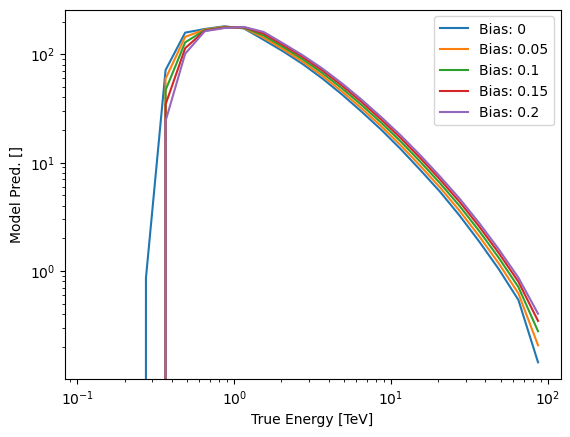

In [8]:
energy_bounds = (0.4, 100 ) *u.TeV
fig,ax = plt.subplots(1,1)
for b in bias_values:
    dataset_asimov_N.models.parameters['bias'].value = b
    npred_s =     dataset_asimov_N.npred_signal(dataset_asimov_N.models[0].name)
    npred_s = npred_s.get_spectrum().data.flatten()
    ax.plot(dataset_asimov_N._geom.axes[0].center.value, npred_s, label = f"Bias: {b}")
    
dataset_asimov_N.models.parameters['bias'].value = 0
    
plt.legend()
plt.loglog()
plt.xlabel("True Energy [TeV]")
plt.ylabel("Model Pred. []")

In [9]:
bias_values = [0,0.05, 0.1, 0.15, 0.2]
energy_bounds = (0.4, 100 ) *u.TeV

fit = Fit()
    
for i, b in enumerate(bias_values):
    dataset_asimov_N.models.parameters['bias'].value = b
    
    datasets[i].edisp = dataset_asimov_N.npred_edisp()
    datasets_N[i].edisp = dataset_asimov_N.npred_edisp()
    
    result = fit.run(datasets[i])
    try:
        result = fit.run(datasets_N[i])
    except:
        print(f"failed for bias: {b}")
    print(result)
    


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 315
	total stat : 850150.22

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 313
	total stat : 850150.42

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 277
	total stat : 850150.98

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

failed for bias: 0.15
OptimizeResult

	backend    : minuit
	method     : migrad
	succes

In [10]:
len(datasets)

5

In [11]:
len(bias_values)

5

Text(0, 0.5, 'Flux')

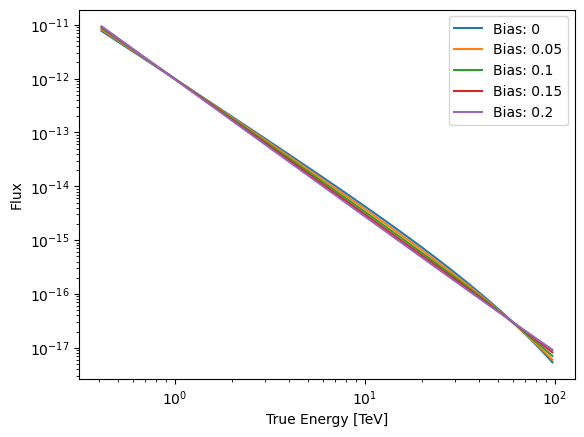

In [12]:
fig,ax = plt.subplots(1,1)
for i, d in enumerate(datasets):
    d.models[0].spectral_model.plot(energy_bounds = energy_bounds, ax =ax,
                                    label = f"Bias: {bias_values[i]}")
plt.legend()
plt.loglog()
plt.xlabel("True Energy [TeV]")
plt.ylabel("Flux")

ValueError: cannot convert float NaN to integer

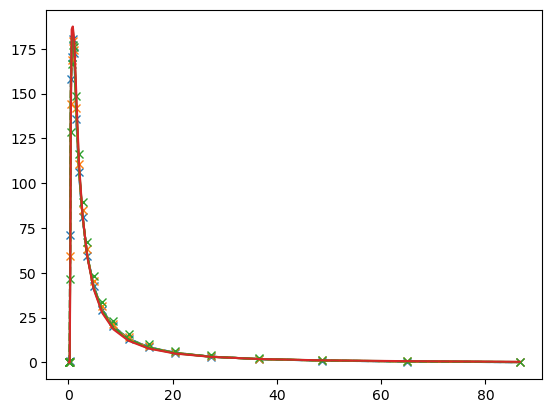

In [13]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig,ax = plt.subplots(1,1)
for i, d in enumerate(datasets):
    npred_s = d.npred_signal(dataset_asimov_N.models[0].name)
    npred_s = npred_s.get_spectrum().data.flatten()
    ax.plot(d._geom.axes[0].center.value, npred_s, label = f"Bias: {bias_values[i]}",
           color = colors[i])
    
    npred_s = datasets_N[i].npred_signal(dataset_asimov_N.models[0].name)
    npred_s = npred_s.get_spectrum().data.flatten()
    ax.plot(d._geom.axes[0].center.value, npred_s, linestyle = 'dashed', label = f"Bias: {bias_values[i]}",
           color = colors[i])
    
    dataset_asimov_N.models.parameters['bias'].value = bias_values[i]
    npred_s =     dataset_asimov_N.npred_signal(dataset_asimov_N.models[0].name)
    npred_s = npred_s.get_spectrum().data.flatten()
    ax.plot(dataset_asimov_N._geom.axes[0].center.value, npred_s, 'x', label = f"Bias: {b}",
           color = colors[i])
    
plt.legend()
plt.loglog()
plt.xlabel("True Energy [TeV]")
plt.ylabel("Flux")

In [ ]:
bias_values_s = np.array(bias_values) + 0.01

In [ ]:
fig , axs = plt.subplots(4,1, sharex = True)
axs[0].errorbar(bias_values, [d.models.parameters['amplitude'].value for d in datasets],
                yerr = [d.models.parameters['amplitude'].error for d in datasets], )
axs[0].errorbar(bias_values_s, [d.models.parameters['amplitude'].value for d in datasets_N],
                yerr = [d.models.parameters['amplitude'].error for d in datasets_N], )
axs[0].set_ylabel("Amplitude")
axs[1].errorbar(bias_values, [d.models.parameters['index'].value for d in datasets],
               yerr = [d.models.parameters['index'].error for d in datasets])
axs[1].errorbar(bias_values_s, [d.models.parameters['index'].value for d in datasets_N],
               yerr = [d.models.parameters['index'].error for d in datasets_N])
axs[1].set_ylabel("index")
axs[2].errorbar(bias_values, [d.models.parameters['lambda_'].value for d in datasets],
               yerr = [d.models.parameters['lambda_'].error for d in datasets])
axs[2].errorbar(bias_values_s, [d.models.parameters['lambda_'].value for d in datasets_N],
               yerr = [d.models.parameters['lambda_'].error for d in datasets_N])
axs[2].set_ylabel("lambda_")

axs[3].errorbar(bias_values_s, [d.models.parameters['bias'].value for d in datasets_N],
               yerr = [d.models.parameters['bias'].error for d in datasets_N])
axs[3].set_ylabel("bias")

axs[2].set_xlabel("Bias %")

In [ ]:
for d in datasets:
    print(d.models)

In [ ]:

energy_power = 2
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
plot_asimov_spectrum(fig, axs)

axs.set_xlim(0.3, 100)